# Code
venv: SDMetrics

# Imports

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.stats import chisquare
from sdmetrics.utils import get_frequencies

# User Configuration

In [2]:
SAVE_FIG = True
SAVE_CSV = True  # Save figures

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

N_BOOTSTRAP = 1000 # 500-1000
SAMPLE_SIZE = 5000 # 5% of Sample size

DATA_DIR = Path("../../data")
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="talk",
    palette="colorblind"
)

# Utility Functions

## Load Data & Assign Correct Datatypes

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

## Own CS-Test Implementation

In [4]:
def compute_cstest_statistic(real_data, synthetic_data):
    f_obs, f_exp = get_frequencies(real_data, synthetic_data)
    chi2_stat, p_val = chisquare(f_obs, f_exp)
    
    return chi2_stat, p_val

def calc_cs_bootstrap_parallel(
    df_real: pd.DataFrame,
    df_synth: pd.DataFrame,
    cat_cols: list,
    n_bootstrap: int = 1000,
    n_sample_size: int = 5000,
    n_jobs: int = -1  # Anzahl Kerne, -1 = alle nutzen
) -> pd.DataFrame:

    def bootstrap_single_iteration(_):
        stats = {}
        for col in cat_cols:
            real_col = df_real[col].dropna().sample(n_sample_size, replace=True)
            synth_col = df_synth[col].dropna().sample(n_sample_size, replace=True)
            
            chi2_stat, chi2_p_value = compute_cstest_statistic(real_col, synth_col)
            stats[col + '_chi2'] = chi2_stat
            stats[col + '_p_value'] = chi2_p_value
        return stats

    # Parallelisieren mit tqdm für Fortschritt
    results = Parallel(n_jobs=n_jobs)(
        delayed(bootstrap_single_iteration)(i) for i in tqdm(range(n_bootstrap), desc="Parallel CS-Bootstrap")
    )
    
    # Umwandeln in DataFrame (Iteration x Feature)
    df_results = pd.DataFrame(results)

    return df_results


In [5]:
def plot_ci_stability(df_results: pd.DataFrame, feature_col: str, bootstrap_sizes: list = None, figsize: Tuple[int, int] = (12, 6)):
    """
    Plots the stability of the 95% confidence interval of the CS Test Statistic
    for a given feature using seaborn.
    
    Args:
        df_results (pd.DataFrame): CS Test statistics (Bootstrap Iterations x Features)
        feature_col (str): Feature to visualize
        bootstrap_sizes (list, optional): List of bootstrap sample sizes to evaluate
    """
    if bootstrap_sizes is None:
        bootstrap_sizes = [10, 50, 100, 200, 500, 1000]
    
    ci_results = []
    for n in bootstrap_sizes:
        sample_stats = df_results[feature_col].iloc[:n]
        lower = np.percentile(sample_stats, 2.5)
        upper = np.percentile(sample_stats, 97.5)
        mean_stat = np.mean(sample_stats)
        
        ci_results.append({
            'n_bootstrap': n,
            'cs_stat_mean': mean_stat,
            'cs_stat_2_5': lower,
            'cs_stat_97_5': upper
        })
    
    df_ci_results = pd.DataFrame(ci_results)
    
    # Plot with seaborn
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.lineplot(data=df_ci_results, x='n_bootstrap', y='cs_stat_mean', marker='o', ax=ax, label='Mean CS Statistic', )
    
    # Confidence Interval fill (manual, asymmetric)
    ax.fill_between(df_ci_results['n_bootstrap'], 
                    df_ci_results['cs_stat_2_5'], 
                    df_ci_results['cs_stat_97_5'], 
                    alpha=0.3, label='95% Confidence Interval')
    
    ax.set_xlabel('Number of Bootstrap Iterations')
    ax.set_ylabel(f'CS Test Statistic ({feature_col})')
    ax.set_title(f'Stability of the 95% Confidence Interval of the CS Test Statistic ({feature_col}) with Increasing Bootstrap Size')
    ax.legend()
    # ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xscale('log')
    
    return fig, ax


In [6]:
def plot_featurewise_ci(df_results: pd.DataFrame, figsize: Tuple[int, int] = (12, 6)):
    """
    Plots CS Test Statistics with 95% Confidence Intervals per Feature using seaborn.
    
    Args:
        df_results (pd.DataFrame): Bootstrap results (Iterations x Features)
    """
    summary = []
    for col in df_results.columns:
        lower = np.percentile(df_results[col], 2.5)
        upper = np.percentile(df_results[col], 97.5)
        mean_stat = df_results[col].mean()
        
        summary.append({
            'feature': col,
            'cs_stat_mean': mean_stat,
            'cs_stat_2_5': lower,
            'cs_stat_97_5': upper
        })
    
    df_summary = pd.DataFrame(summary)
    
    # Fehlerbalken (hue-less)
    df_summary['err_low'] = df_summary['cs_stat_mean'] - df_summary['cs_stat_2_5']
    df_summary['err_high'] = df_summary['cs_stat_97_5'] - df_summary['cs_stat_mean']
    
    # Für seaborn -> barplot mit Custom CI (zwei Seiten unterschiedlich => Pointplot+manual errorbars)
    fig, ax = plt.subplots(figsize=figsize)

    sns.pointplot(
        data=df_summary,
        x='feature',
        y='cs_stat_mean',
        linestyle='none',
        capsize=0.2,
        color='steelblue',
        ax=ax
    )
    
    # Fehlerbalken manuell (weil asymmetrisch)
    for i, row in df_summary.iterrows():
        err_low = max(0, abs(row['err_low']))
        err_high = max(0, abs(row['err_high']))

        ax.errorbar(
            x=i, 
            y=row['cs_stat_mean'], 
            yerr=[[err_low], [err_high]], 
            fmt='none', 
            # ecolor='red', 
            elinewidth=1.5, 
            capsize=5
        )

    ax.set_xlabel('Feature')
    ax.set_ylabel('CS Test Statistic')
    ax.set_title('CS Test Statistics with 95% Confidence Intervals per Feature')
    plt.xticks(ticks=range(len(df_summary['feature'])), labels=df_summary['feature'], rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    return fig, ax


# Main Routine
## Daten Laden

In [7]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)

In [8]:
num_attrs = df_real.select_dtypes(include=['number']).columns
cat_attrs = df_real.select_dtypes(exclude=['number']).columns

# Bootstrap

In [9]:
df_results = calc_cs_bootstrap_parallel(df_real, df_synth, cat_cols=cat_attrs, n_bootstrap=N_BOOTSTRAP, n_sample_size=SAMPLE_SIZE)


Parallel CS-Bootstrap: 100%|██████████| 1000/1000 [00:48<00:00, 20.77it/s]


In [10]:
if SAVE_CSV:
    # Speichern der Ergebnisse in CSV-Dateien
    df_results.to_csv(OUTPUT_DIR_CSV / f"cs_bootstrap_{N_BOOTSTRAP}_results.csv", index=False, sep=";", decimal=",", encoding="utf-8")
    print(f"Bootstrap results saved to {OUTPUT_DIR_CSV / f'cs_bootstrap__{N_BOOTSTRAP}_results.csv'}")

Bootstrap results saved to results\cs_bootstrap__1000_results.csv


In [11]:
df_plot = df_results.filter(like='_chi2')
print(df_plot.head())

   icu_admission_24h_chi2  gender_chi2  ethnicity_chi2  \
0                0.008555     0.023908        0.060528   
1                0.011355     0.023876        0.054193   
2                0.005876     0.019980        0.043277   
3                0.005891     0.024470        0.055806   
4                0.006806     0.030012        0.021719   

   consciousness_level_chi2  news_score_chi2  night_arrival_chi2  \
0                  0.029948         0.054032            0.000542   
1                  0.029389         0.054969            0.001275   
2                  0.027483         0.046560            0.000659   
3                  0.034364         0.051986            0.002476   
4                  0.031679         0.052691            0.003172   

   weekend_arrival_chi2  chief_complaint_chi2  icd_block_chi2  
0              0.105192         128000.321976    45400.434905  
1              0.076336          76200.364887    49800.463383  
2              0.095581         103600.294675    5

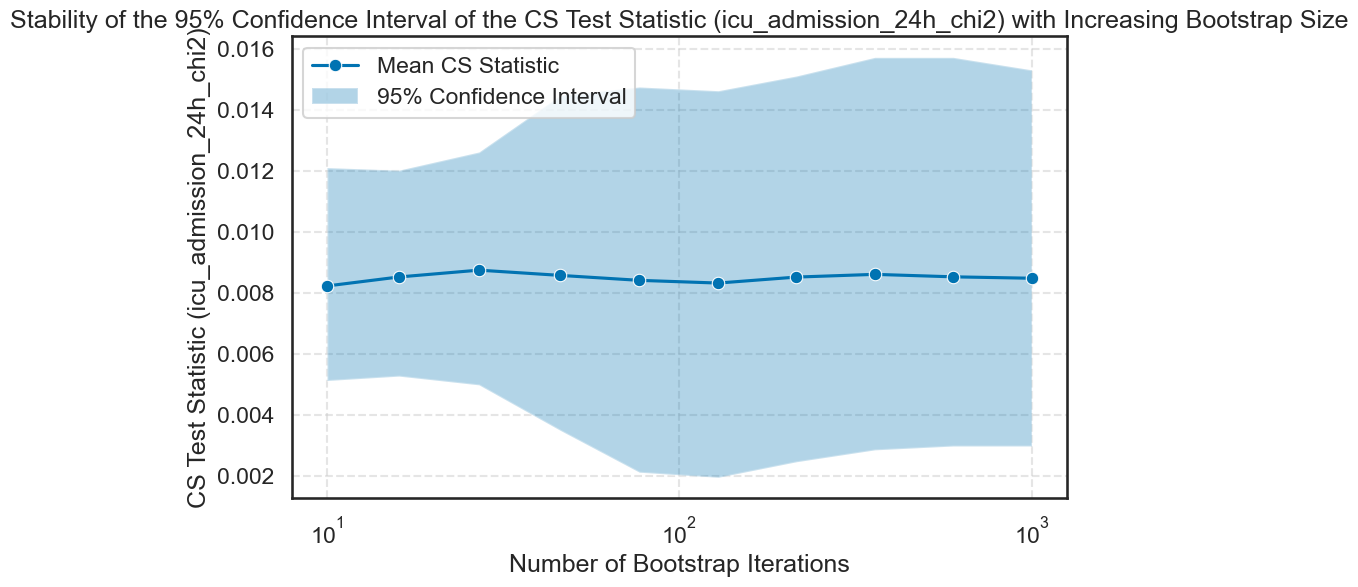

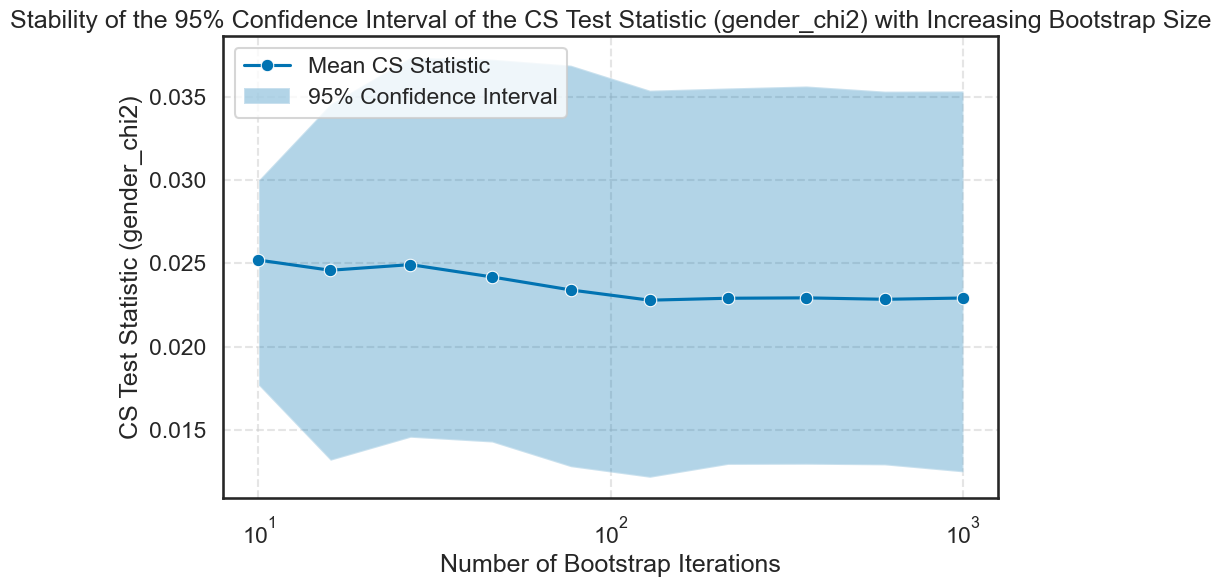

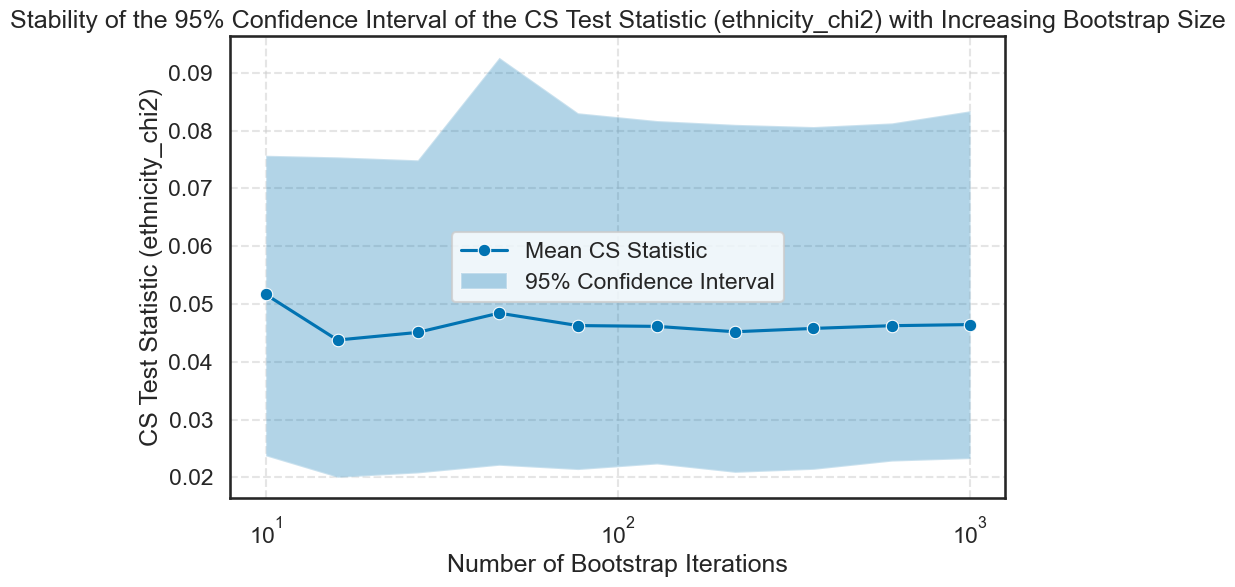

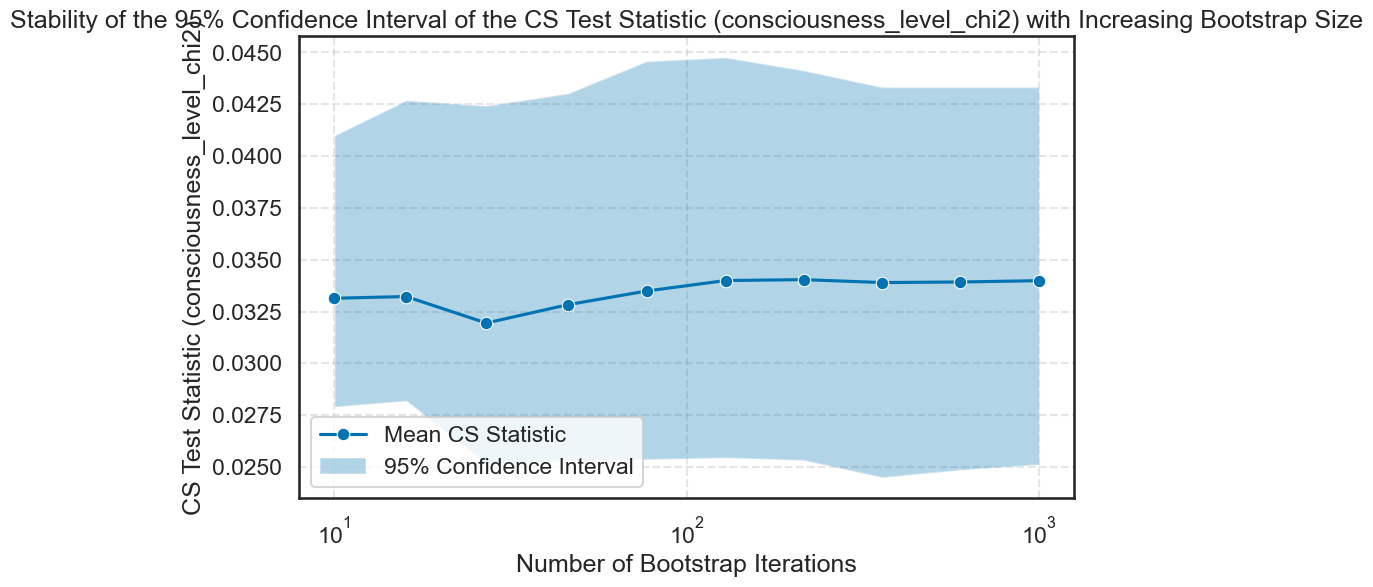

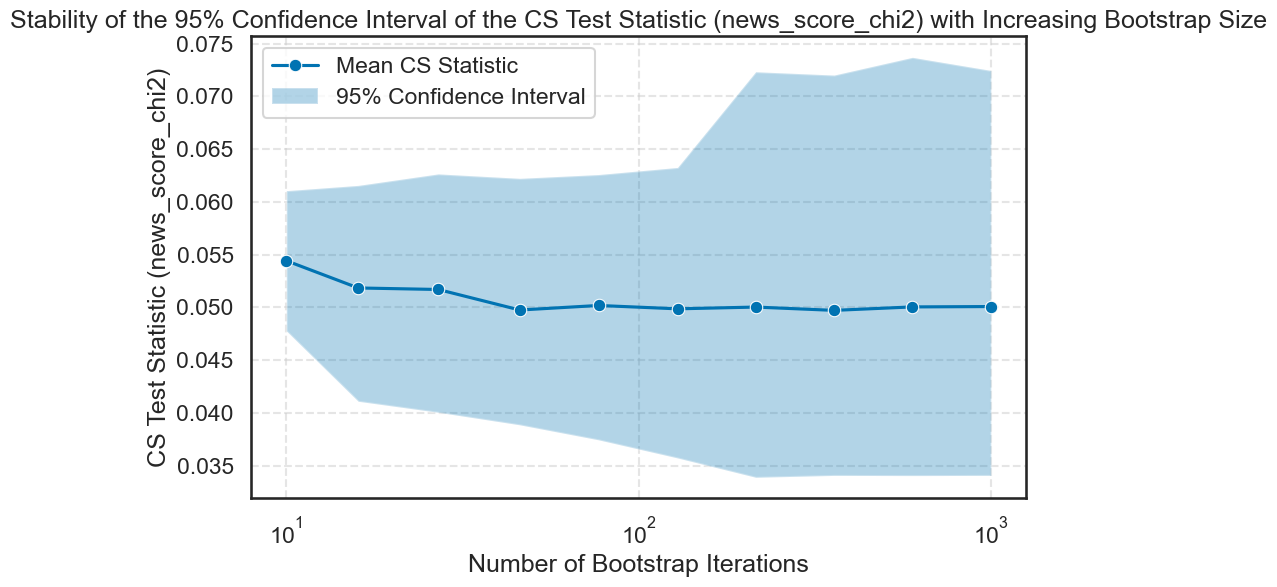

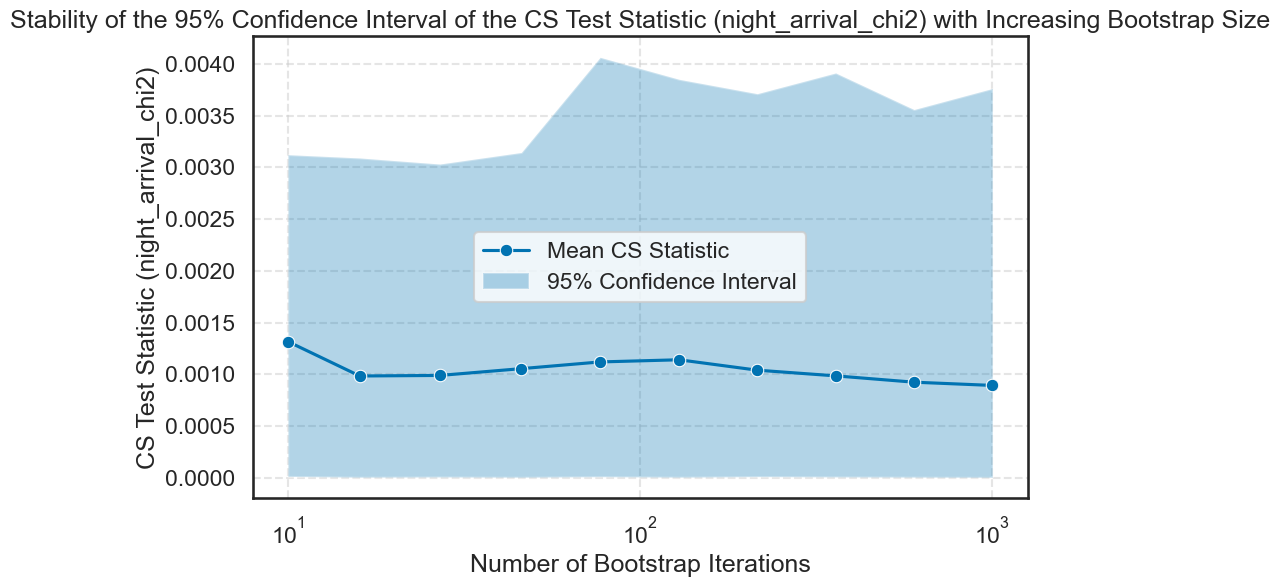

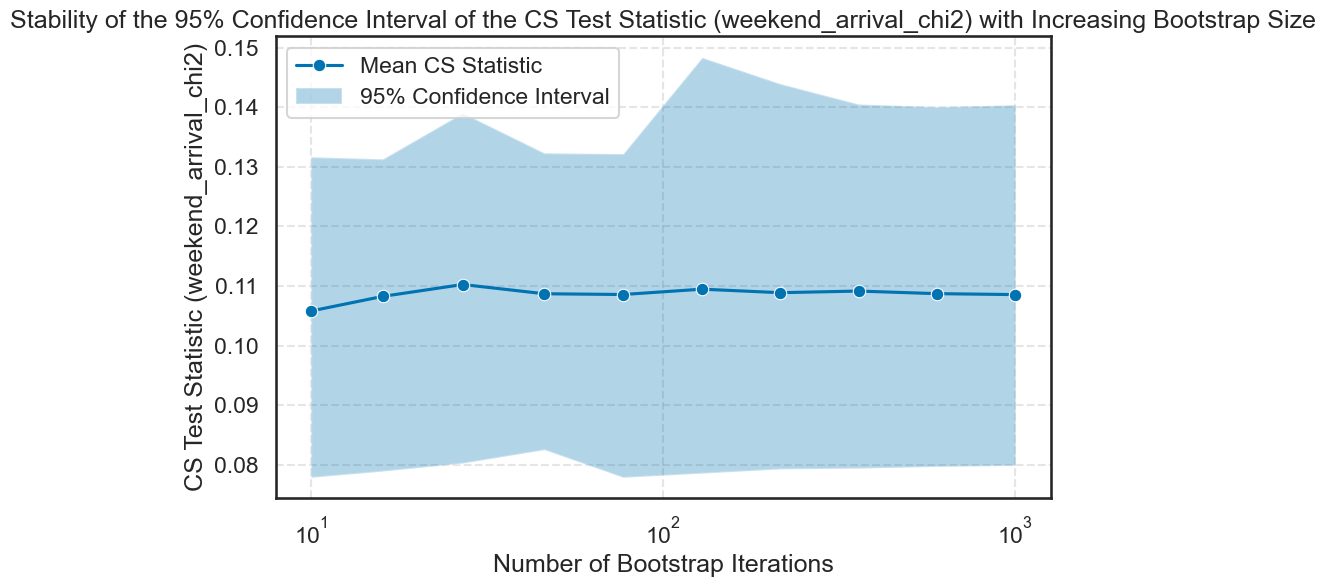

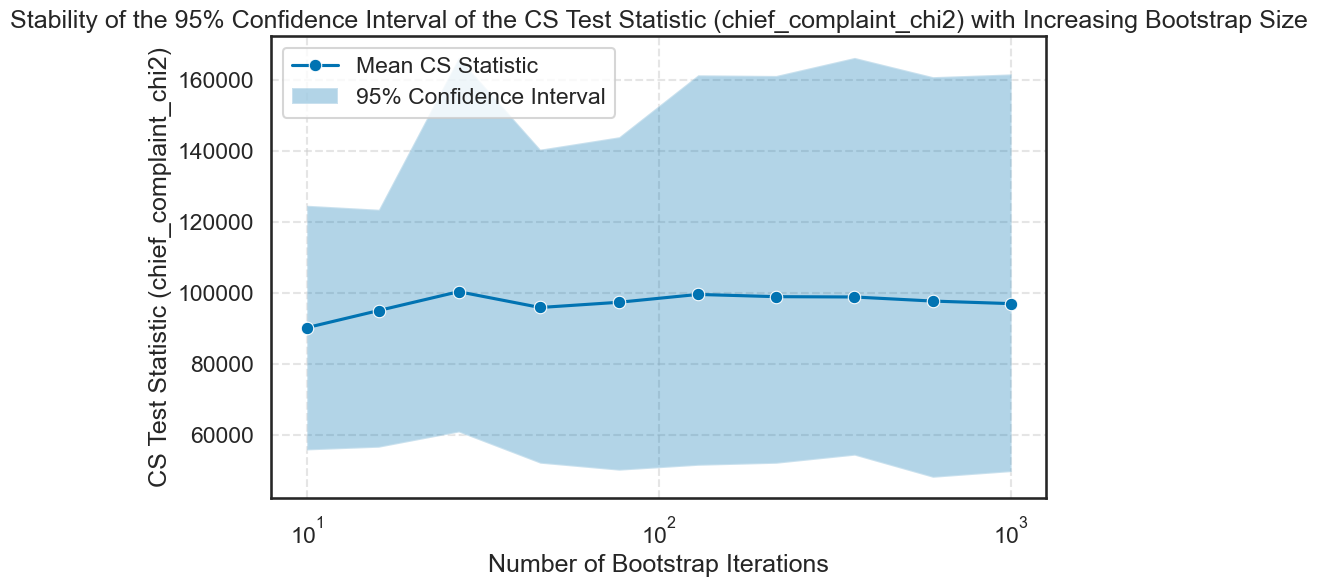

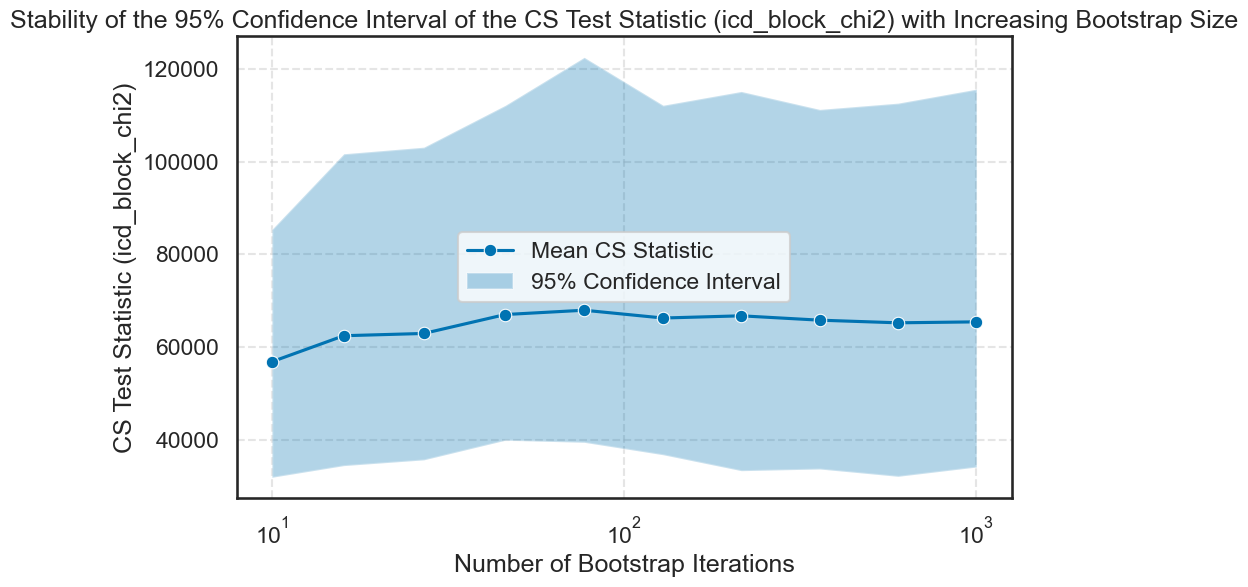

In [ ]:
# bootstrap_sizes = np.linspace(10, N_BOOTSTRAP, N_STEPS, dtype=int).tolist()
bootstrap_sizes = np.unique(np.geomspace(10, N_BOOTSTRAP, num=10, dtype=int)).tolist()

# attr = "age"

for attr in df_real[cat_attrs]:
    fig, ax = plot_ci_stability(df_results=df_plot, feature_col=f'{attr}_chi2', bootstrap_sizes=bootstrap_sizes, figsize=(8, 6))
    plt.show()
    if SAVE_FIG:
        output_dir_ci = OUTPUT_DIR_FIG / "CS_CI-Sability"
        output_dir_ci.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_dir_ci / f"cs-test_ci_stability_{attr}_{N_BOOTSTRAP}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    plt.close(fig)

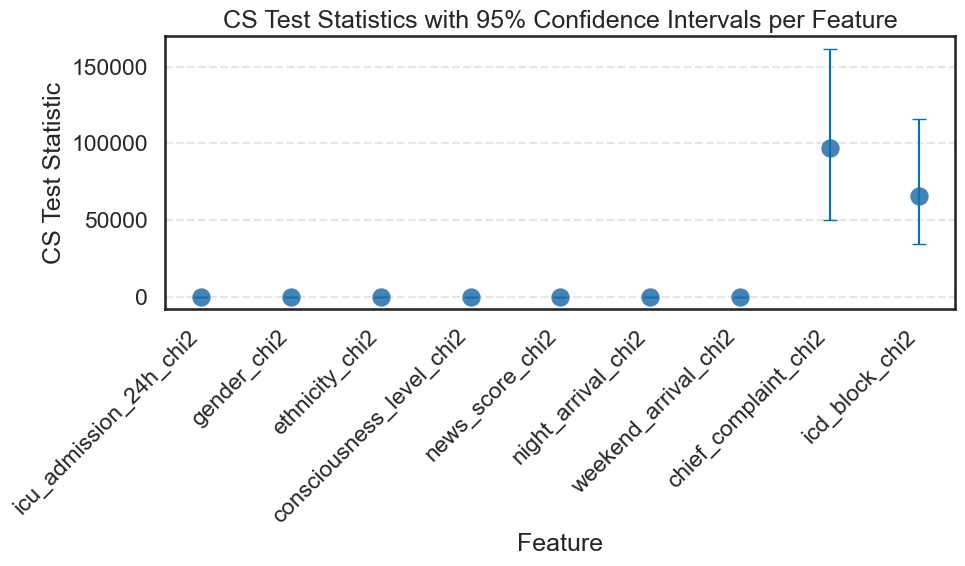

In [17]:
fig, ax = plot_featurewise_ci(df_plot, figsize=(10, 6))
plt.show()
if SAVE_FIG:
    fig.savefig(OUTPUT_DIR_FIG / f"cs-test-stats_all_features_{N_BOOTSTRAP}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)